# Prepare the data

In [1]:
import re
import json
import pandas as pd
import spacy
pd.set_option("display.max_colwidth", 4000)
pd.set_option("display.max_rows", 4000)

from tqdm import tqdm
tqdm.pandas()

# Load the model and data files
spacy_model = spacy.load("en_core_web_sm")

with open("../investigation_notebooks/train_samples.jsonl", "r") as f:
    lines = [l.strip() for l in f]
df = pd.DataFrame([json.loads(l) for l in lines])

# Tokenize the summaries
df["summary_tokens"] = df["summary"].progress_apply(lambda s: [t.text for t in spacy_model(s)])

# Compute the modified density
df["modified_density"] = df.apply(lambda row: row["density"] / len(row["summary_tokens"]), axis=1)

# Find the new thresholds
th1, th2 = df["modified_density"].quantile(1/3), df["modified_density"].quantile(2/3)
cov_th = 0.85

# Don't also consider high coverage summaries as abstractive ones
df["modified_density_bin"] = df.apply(
    lambda row: "abstractive"
    if row["modified_density"] <= th1 and row["coverage"] <=cov_th
    else "mixed"
    if row["modified_density"] <= th2
    else "extractive",
    axis=1,
)

# Slice only part of the dataset
df = df[df["density_bin"] != "extractive"].copy().reset_index(drop=True)



100%|██████████| 10000/10000 [01:33<00:00, 106.61it/s]


# Heuristic 1: Percentage of tokens inside quotes

In [2]:
def compute_quotes_coverage(summary_tokens):
    """
    Compute the quotes coverage for a summary
    
    summary_tokens: A list of strings (tokens)
    
    returns:
    A value in range [0, 1] representing the percentage of tokens
    that are enclosed in quotes
    """
    n_tokens_inside = 0
    # Keep track of nested quotes
    quotes_stack = []
    # Count the number of tokens inside the current quotes range
    tokens_in_quotes = []

    # TODO: Is single quotation ' needed as well?
    quotes = '”“‘’"'

    for token in summary_tokens:
        #  This token is inside a candidate quotes range
        if quotes_stack and token not in quotes:
            tokens_in_quotes[-1] += 1

        # The current token is a quotation
        if token in quotes:
            # This is the end of a quotes range
            if quotes_stack and abs(ord(token) - ord(quotes_stack[-1])) <= 1:
                quotes_stack.pop(-1)
                # Increment the number of tokens inside quotes range
                # only when the range ends
                n_tokens_inside += tokens_in_quotes[-1]
                tokens_in_quotes.pop(-1)

            # This is the start of a new range
            else:
                quotes_stack.append(token)
                tokens_in_quotes.append(0)

    n_non_quotes_tokens = len(
        [token for token in summary_tokens if token not in quotes]
    )
    return n_tokens_inside / n_non_quotes_tokens

In [3]:
df["quotes_coverage"] = df.progress_apply(
    lambda row: (compute_quotes_coverage(row["summary_tokens"])), axis=1,
)

100%|██████████| 6592/6592 [00:00<00:00, 48003.65it/s]


In [4]:
df.sort_values(by="quotes_coverage", ascending=False)[
    [
        "density_bin",
        "modified_density_bin",
#         "modified_density",
#         "density",
        "quotes_coverage",
        "summary",
        "title"
    ]
].head(10)

,density_bin,modified_density_bin,quotes_coverage,summary,title
2930,mixed,extractive,1.0,"""I approved it, and I'll do it again if presented with the same circumstances""",Dallas Police Chief Defends Use of 'Bomb Robot' on Suspect
5764,mixed,extractive,1.0,"""Each day the Sami are reminded of their dependence on nature, and the fragility of that relationship.""",Off the Grid: Preserving the tradition of reindeer herding in Scandinavia’s Sami culture
5269,mixed,extractive,1.0,"""I have concluded that person cannot be me""",Boris Johnson Drops Out of Conservative Leadership Race
3717,abstractive,mixed,1.0,"""I double dare you.""",18 GIFs That Sum Up Playing Truth Or Dare
4987,abstractive,mixed,1.0,"""It's been very humbling.""",Meet the Photographer Behind Baton Rouge Photo
574,mixed,mixed,1.0,"‘The photographer called it Bankers At Leadenhall Market, but everyone in the picture actually works in insurance’","That’s me in the picture: Patrick Sheehy drinking a pint in Leadenhall Market, London, December 2011"
5249,abstractive,mixed,1.0,"""I have three questions for you.""","Arnold Schwarzenegger to Climate Change Deniers: ""I Don't Give a Damn"""
4153,abstractive,abstractive,1.0,"""Hey Jimmy... I farted.""",Kevin Hart got so scared in a haunted house with Jimmy Fallon that he farted
2996,mixed,extractive,1.0,"“Where is she? If there's no ashes and there's no baby, what did he do with her?”",Police found 12 bodies in a storage unit three weeks ago. So why isn’t anyone facing charges yet?
2612,abstractive,mixed,1.0,"""There is nothing there.""",How four words rewrote Bayer-Monsanto deal script


In [5]:
# Find the number of percentage of samples having
# quotes coverage that is higher than 0.8!
df[df["quotes_coverage"]>=0.8].shape[0]

17

In [6]:
df["quotes_coverage"].describe()

count    6592.000000
mean        0.017105
std         0.081639
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: quotes_coverage, dtype: float64

### Check the relation between quotes_coverage and density

In [7]:
import seaborn as sns

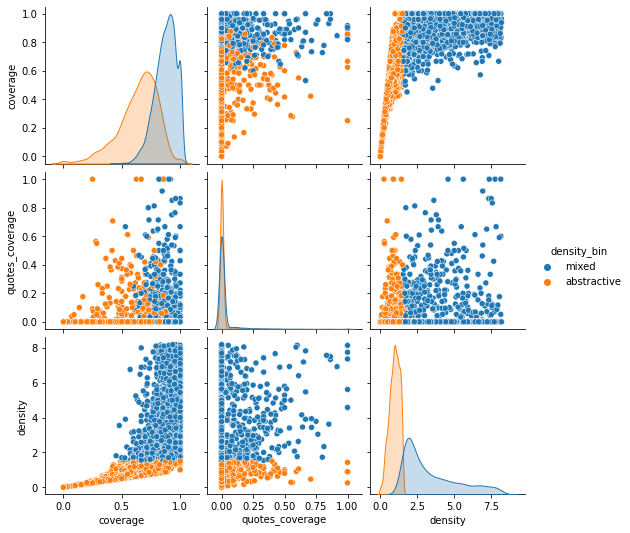

In [8]:
sns.pairplot(
    data=df[["density_bin", "coverage", "quotes_coverage", "density"]],
    hue="density_bin",
)

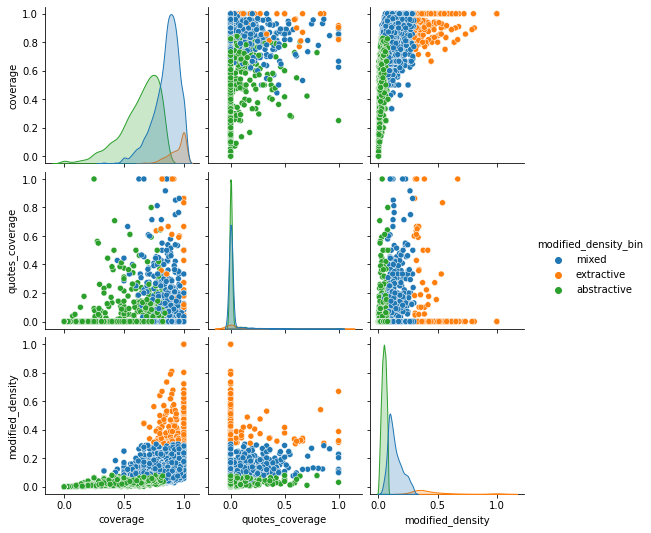

In [9]:
sns.pairplot(
    data=df[["modified_density_bin", "coverage", "quotes_coverage", "modified_density"]],
    hue="modified_density_bin",
    hue_order=["mixed", "extractive", "abstractive"]
)

# Heuristic 2: Having a strange ending

In [10]:
def has_strange_ending(summary):
    """
    Check if the summary ends abruptly
    summary_tokens: A string

    returns:
    A boolean value
    """
    summary_tokens = spacy_model(summary)

    last_token_text = summary_tokens[-1].text.lower()
    # List of pos tags can be found through: https://universaldependencies.org/u/pos/
    last_token_pos = summary_tokens[-1].pos_

    if last_token_text in ".":
        return False

    if last_token_text in ",":
        return True

    if (
        last_token_pos in ["DET", "INTJ", "CCONJ", "AUX", "SCONJ", "X"]
        and last_token_text != "all"
    ):
        return True

    if last_token_pos == "PRON" and last_token_text in ["what", "who", "which", "that"]:
        return True

    return False

In [11]:
df["has_strange_ending"] = df["summary"].progress_apply(has_strange_ending)

100%|██████████| 6592/6592 [00:52<00:00, 125.42it/s]


In [12]:
df.loc[df["has_strange_ending"] == True, ["summary"]].shape

(80, 1)

In [13]:
df.loc[df["has_strange_ending"] == True, ["summary"]].sample(20)#, random_state=42)

,summary
4933,"Body of Purdue football player Sean Matti found in lake - Campus Rivalry: College Football & Basketball News, Recruiting, Game Picks, and More - USATODAY.com"
5508,"Kenny Rogers denies asking for money during Cam Newton's recruitment - Campus Rivalry: College Football & Basketball News, Recruiting, Game Picks, and More - USATODAY.com"
3696,"Everyone has a weakness. For me, it's salted caramel ice cream. For my dog, Lulu, it's expensive shoes. For most cats, it's catnip.Here are five things every cat lover should know about this"
6564,"Tyshawn Taylor reinstated at Kansas, will suit up Wednesday - Campus Rivalry: College Football & Basketball News, Recruiting, Game Picks, and More - USATODAY.com"
2135,Rutgers pays Snooki more than Toni Morrison - USATODAY.com
5708,"<p>&nbsp;The cast of <em>Sex and the City 2</em>, Sarah Jessica Parker, left, Kristin Davis, Cynthia Nixon and Kim Cattrall, &nbsp;pose for a photo at the premiere at Radio City Music Hall in New York on Monday. The film is in theaters Friday.</p>"
515,"A West Virginia county is grappling with allegations of sexual assaults at a middle school, and accusations that"
1462,"NCAA responds to Lute Olson's comments about investigation at Arizona - Campus Rivalry: College Football & Basketball News, Recruiting, Game Picks, and More - USATODAY.com"
4292,Arctic could be a tipping point for warming - Science Fair: Science and Space News - USATODAY.com
5216,Browse stories from Walt Bonner on FoxNews.com


# Heuristic 3: Summary is too short
Implemented directly in snorkel

# Heuristic 4: Summary is just a date
- Implemented directly in snorkel
- TODO: What if the date is just a substantial part of a strapline?
    - How to detect this case?

# TODO
- Heuristic 5: Bad summaries can contain html/js/css code
- Heuristic 6: A strapline can occur multiple times in the dataset
- Heuristic 7: A strapline uses 2nd person pronouns (you, ??)
- Heuristic 8: A strapline can be a single question

Other ideas:
- Heuristic 9: A bad summary is longer than the article itself

# Use snorkel

In [14]:
import dateutil
from snorkel.labeling import labeling_function

# NOTE: I am afraid of returning a NOT_STRAPLINE label
# based on any of the heuristics so I am just ABSTAINing 

ABSTAIN = -1
NOT_STRAPLINE = 0
STRAPLINE = 1


@labeling_function()
def lf_mostly_quotes(x):

    quotes_coverage = compute_quotes_coverage(x["summary_tokens"])
    return (
        STRAPLINE
        if quotes_coverage > 0.6
        else ABSTAIN
    )


@labeling_function()
def lf_strange_ending(x):
    strange_ending = has_strange_ending(x["summary"])
    return STRAPLINE if strange_ending else ABSTAIN


@labeling_function()
def lf_too_short(x):
    summary_n_tokens = len(x["summary_tokens"])
    return (
        STRAPLINE
        if summary_n_tokens <= 5
        else ABSTAIN
    )


@labeling_function()
def lf_is_a_date(x):
    try:
        # Attempt to parse the text as a date
        dateutil.parser.parse(x["summary"])
        return STRAPLINE
    except:
        return ABSTAIN

In [15]:
from snorkel.labeling import PandasLFApplier

lfs = [lf_mostly_quotes, lf_strange_ending, lf_too_short, lf_is_a_date]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df)

100%|██████████| 6592/6592 [00:52<00:00, 125.29it/s]


In [16]:
# Check the labels assigned to the samples by the labeling functions
L_train

array([[-1, -1,  1, -1],
       [-1, -1, -1, -1],
       [-1, -1,  1, -1],
       ...,
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1]])

In [17]:
# Check the overlaps/conflicts between labeling functions
# Note: No conflicts for now since I am not using the NOT_STRAPLINE label
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_mostly_quotes,0,[1],0.004703,0.000000,0.0
lf_strange_ending,1,[1],0.012136,0.000303,0.0
lf_too_short,2,[1],0.022603,0.000607,0.0
lf_is_a_date,3,[1],0.000303,0.000303,0.0


In [18]:
from snorkel.labeling.model import LabelModel

# Merge the labels into a single label with probability
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

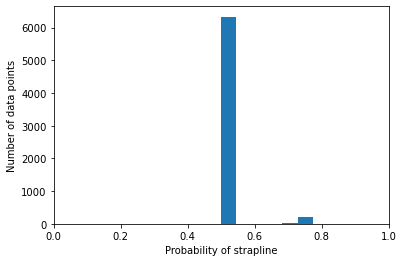

In [19]:
import matplotlib.pyplot as plt

def plot_probabilities_histogram(Y, label):
    plt.hist(Y, bins=10)
    plt.xlabel(f"Probability of {label}")
    plt.ylabel("Number of data points")
    plt.xlim(0, 1)
    plt.show()

probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, STRAPLINE], "strapline")

# Detected straplines
- Check the samples having probability > 0.5

In [20]:
number_of_straplines = df.loc[(probs_train[:, 1] > 0.5), ["summary"]].shape[0]
print(
    f"""{number_of_straplines} straplines in the sample dataset
Representing {round(100 * number_of_straplines / df.shape[0], 2)}% of it"""
)

258 straplines in the sample dataset
Representing 3.91% of it


In [21]:
df["probability_of_being_strapline"] = probs_train[:,1]

In [22]:
# This is the last cell in the notebook
# It's too long since it's showing all the detected straplines
df.loc[
    (probs_train[:, 1] > 0.5), ["summary", "probability_of_being_strapline", "title"]
].sort_values(by="probability_of_being_strapline", ascending=False)

,summary,probability_of_being_strapline,title
755,"October 4, 2013",0.957386,Overprescribed Antibiotics and Other Fascinating News on the Web
1095,"August 4, 2014",0.957386,The Booming Instant Gratification Economy and Other Fascinating News on the Web
3070,http://images.scribblelive.com/2015/10/2/222b607e-4b1f-45e4-a8bd-733c18ca0f40.jpg,0.892514,The battle for Syria
800,V-12 SA Aperta to be,0.892514,"V-12 SA Aperta to be ""most exclusive Ferrari ever"""
0,CEO FAJR CAPITAL,0.742958,Iqbal Khan - Telegraph
3463,This is awkward.,0.742958,Gwyneth Paltrow can’t believe she’s the most hated celebrity
3525,Talk about going undercover(s),0.742958,Burglar Covered in Duvet from Bed for a Child
3538,Better call Walter White.,0.742958,Bryan Cranston could appear in 'Better Call Saul' if asked
3568,But%20many%20refinancing%20applicants%20are%20unable%20to%20get%20approved%20at%20interest%20rates%20they%20want.,0.742958,"Despite Low Mortgage Rates, Many Won't Be Able to Refinance"
3685,...,0.742958,"State AG probes Apple, Amazon over e-Book prices"
